In [2]:
# =================================================================
# H1: Temiz Veri Setini Yükle + Hızlı Sağlık Kontrolü
# =================================================================

import pandas as pd
import numpy as np

# --- Dosya yolu (02_data_preprocessing çıktısı)
CLEAN_PATH = "../data/clean/gps_locations_clean.csv"

# --- Yükle
df = pd.read_csv(CLEAN_PATH, parse_dates=["timestamp"])

print("[OK] Temiz veri yüklendi:", CLEAN_PATH)
print("Boyut  :", f"{len(df):,} x {df.shape[1]}")
print("Örnek  :")
display(df.head(3))

# --- Önemli not: `trip_id` yerine `trip_seg_id` kullanacağız
# Bu, 02_data_preprocessing not defterinde yapılan segmentasyondur.
if "trip_id" in df.columns:
    del df["trip_id"]

# --- Gerekli asgari sütunlar
required_cols = [
    "timestamp", "vehicle_id", "driver_id", "trip_seg_id",
    "latitude", "longitude", "speed", "acceleration"
]

missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Gerekli sütun(lar) eksik: {missing}")

# --- Tip kontrolü (kritik alanlar)
type_expect = {
    "timestamp": "datetime64[ns]",
    "vehicle_id": None,
    "driver_id": None,
    "trip_seg_id": None,
    "latitude": None,
    "longitude": None,
    "speed": None,
    "acceleration": None
}

print("\n[Bilgi] Temel tip özeti:")
print(df[["timestamp","vehicle_id","driver_id","trip_seg_id","latitude","longitude","speed","acceleration"]].dtypes)

# --- Boşluk & aralık kontrolü
na_summary = df[required_cols].isna().sum().sort_values(ascending=False)
print("\n[Boşluk Kontrolü] İlk 10:")
print(na_summary.head(10))

# --- Zaman aralığı
tmin, tmax = df["timestamp"].min(), df["timestamp"].max()
print("\n[Zaman Aralığı]")
print("Başlangıç:", tmin)
print("Bitiş    :", tmax)

# --- Hafif optimizasyon: kimlik/bağlamsal alanları kategoriye çevir (varsa)
for col in ["vehicle_id","driver_id","day_of_week","weather_conditions","road_type","traffic_condition"]:
    if col in df.columns:
        df[col] = df[col].astype("category")

print("\n[Özet] Yükleme & kontrol tamam. Veri feature engineering'e hazır.")

[OK] Temiz veri yüklendi: ../data/clean/gps_locations_clean.csv
Boyut  : 119,817 x 36
Örnek  :


,trip_id,driver_id,vehicle_id,timestamp,latitude,longitude,speed,acceleration,steering_angle,heading,...,date,hour,day_of_week,is_ts_missing,is_gps_valid,is_speed_suspect,time_diff_sec,new_seg,trip_seg_local,trip_seg_id
0,1,101,1001,2023-01-01 00:00:00,38.916143,-80.345269,39.484646,3.612832,6,212.555994,...,2023-01-01,0,Sunday,0,1,0,0.0,1,1,1
1,6,101,1001,2023-01-01 00:00:05,46.670788,-96.459125,53.582790,3.311600,19,66.936837,...,2023-01-01,0,Sunday,0,1,0,5.0,0,1,1
2,10,103,1001,2023-01-01 00:00:09,42.731518,-79.850442,68.856299,2.287190,12,46.717128,...,2023-01-01,0,Sunday,0,1,0,4.0,0,1,1



[Bilgi] Temel tip özeti:
timestamp       datetime64[ns]
vehicle_id               int64
driver_id                int64
trip_seg_id              int64
latitude               float64
longitude              float64
speed                  float64
acceleration           float64
dtype: object

[Boşluk Kontrolü] İlk 10:
timestamp       0
vehicle_id      0
driver_id       0
trip_seg_id     0
latitude        0
longitude       0
speed           0
acceleration    0
dtype: int64

[Zaman Aralığı]
Başlangıç: 2023-01-01 00:00:00
Bitiş    : 2023-01-02 09:19:59

[Özet] Yükleme & kontrol tamam. Veri feature engineering'e hazır.


### Hücre 1: Temiz Veriyi Yükleme ve Sağlık Kontrolü

Bu hücre, bir önceki adımda (02_data_preprocessing.ipynb) temizlenmiş ve yolculuk segmentlerine ayrılmış veriyi yükler.

Yükleme işleminin yanı sıra, verinin beklendiği gibi olduğundan emin olmak için hızlı bir "sağlık kontrolü" yapar:
- **Dosya Kontrolü:** `gps_locations_clean.csv` dosyasının varlığını ve boyutunu doğrular.
- **Sütun Kontrolü:** Özellik mühendisliği için gerekli olan `trip_seg_id` ve diğer temel sütunların mevcut olup olmadığını kontrol eder.
- **Veri Kalite Kontrolü:** Eksik değerleri ve zaman aralığı tutarsızlıklarını inceler.

Bu adım, sonraki işlemlerin (özellik mühendisliği ve anomali tespiti) doğru veri üzerinde çalışmasını sağlar ve önceki hataların tekrarlanmasını engeller.

In [3]:
# =========================================================
# H2: Geofence Kontrolü (Kural Tabanlı Anomali)
# Amaç: Her bir GPS noktasının tanımlı bir güvenli alan içinde olup olmadığını
# kontrol etmek ve anomali bayrağı eklemek.
# =========================================================

import geopy.distance

print("=== Geofence Kontrolü (H2) ===")

# --- Parametreler
# Güvenli Alan Tanımı (örnek: merkez ve yarıçap)
# Bu değerler, gerçek bir projede bir VTYS veya yapılandırma dosyasından gelebilir.
GEOFENCE_CENTER = (40.7128, -74.0060) # New York City
GEOFENCE_RADIUS_KM = 50                 # 50 km yarıçap

# GPS sapmalarını filtrelemek için Debounce mantığı
DEBOUNCE_COUNT = 3 # Geofence dışına çıkış için ardışık 3 nokta şartı

# 1) Her bir GPS noktasının geofence merkezine olan mesafesini hesapla
# Haversine formülü ile küre üzerindeki iki nokta arası mesafe
df['distance_from_center'] = df.apply(
    lambda row: geopy.distance.geodesic((row['latitude'], row['longitude']), GEOFENCE_CENTER).km,
    axis=1
)

# 2) Anomali bayrağı: Yarıçap dışına çıkış
df['geofencing_violation'] = (df['distance_from_center'] > GEOFENCE_RADIUS_KM).astype(int)

# 3) Debounce mantığı: Ardışık geofence ihlallerini say
# Bu, tekil GPS sapmalarını filtrelemeye yardımcı olur.
df['consecutive_violation'] = df.groupby('trip_seg_id')['geofencing_violation'].rolling(
    window=DEBOUNCE_COUNT, min_periods=1
).sum().astype(int).reset_index(level=0, drop=True)

# 4) Debounce kuralını uygula
df['geofencing_violation_debounced'] = (df['consecutive_violation'] >= DEBOUNCE_COUNT).astype(int)

# 5) Özet Rapor
n_violations_raw = df['geofencing_violation'].sum()
n_violations_debounced = df['geofencing_violation_debounced'].sum()

print(f"Toplam ham geofence ihlali: {n_violations_raw:,}")
print(f"Debounce sonrası geçerli ihlal: {n_violations_debounced:,}")

print("\n[TAMAMLANDI] Geofence kontrolü tamamlandı. Veri setine anomali bayrağı eklendi.")
print(f"Son satır/sütun boyutu: {df.shape[0]:,} x {df.shape[1]}")

=== Geofence Kontrolü (H2) ===
Toplam ham geofence ihlali: 119,729
Debounce sonrası geçerli ihlal: 119,543

[TAMAMLANDI] Geofence kontrolü tamamlandı. Veri setine anomali bayrağı eklendi.
Son satır/sütun boyutu: 119,817 x 38


### Hücre 2: Kural Tabanlı Geofence Algoritması

Bu hücre, projenin "kural tabanlı" anomali tespiti kısmını gerçekleştirir. Belirlenen bir "güvenli alan" (geofence) dışına çıkan tüm GPS noktalarını tespit ederek bir anomali bayrağı ekler.

Bu hücrede iki temel işlem yapılır:
1.  **Mesafe Hesaplaması:** Her bir GPS noktasının, tanımlanan geofence merkezine olan kuş uçuşu mesafesi hesaplanır.
2.  **Debounce Mantığı:** Tekil ve rastgele GPS sapmalarını filtrelemek için bir `debounce` kuralı uygulanır. Bir konumun anomali olarak işaretlenmesi için, art arda belirli sayıda (`DEBOUNCE_COUNT`) geofence dışı nokta olması gerekir. Bu, hatalı alarmların önüne geçer.

Bu hücrenin çıktısı, `geofencing_violation_debounced` adında yeni bir sütun ekleyerek her bir noktanın geofence durumunu belirtir.

In [4]:
# =========================================================
# Hücre 3: Yolculuk-Temelli Özet Özellikler (tip-uyumlu v2)
# Gerekenler: df içinde 'trip_seg_id', 'timestamp', 'speed'
# Opsiyonel: 'heading', 'acceleration'
# =========================================================

# --- Güvence: zorunlu kolonlar
need = ["trip_seg_id", "timestamp", "speed"]
miss = [c for c in need if c not in df.columns]
if miss:
    raise KeyError(f"Gerekli kolon(lar) eksik: {miss}")

# --- (Opsiyonel) heading tabanlı yön değişimi
if "heading" in df.columns:
    df["_heading_prev"] = (
        df.groupby("trip_seg_id", observed=True)["heading"].shift(1)
    )
    raw = (df["heading"] - df["_heading_prev"]).abs()
    # 0..360 wrap'ı pandas ile çöz: iki serinin min'ini al
    heading_diff = (
        pd.concat([raw, 360 - raw], axis=1)
          .min(axis=1)
          .fillna(0.0)
    )
    df["_heading_diff"] = heading_diff
    df["_dir_change"] = (heading_diff > 30).astype(int)  # eşik: 30°
else:
    df["_heading_diff"] = 0.0
    df["_dir_change"] = 0

# --- Segment bazlı özetler (named aggregation, Pylance-uyumlu)
seg_base = (
    df.groupby("trip_seg_id", as_index=False, observed=True)
      .agg(
          rows=("timestamp", "size"),
          start_time=("timestamp", "min"),
          end_time=("timestamp", "max"),
          duration_min=("timestamp", lambda s: (s.max() - s.min()).total_seconds()/60.0),
          mean_speed=("speed", "mean"),
          max_speed=("speed", "max"),
          std_speed=("speed", "std"),
          mean_headchg=("_heading_diff", "mean"),
          dirchg_rate=("_dir_change", "mean"),
      )
)

# --- Acceleration varsa dinamik olarak ekle
if "acceleration" in df.columns:
    acc = (
        df.groupby("trip_seg_id", as_index=False, observed=True)
          .agg(
              mean_acc=("acceleration", "mean"),
              max_acc=("acceleration", "max"),
              std_acc=("acceleration", "std"),
          )
    )
    seg_base = seg_base.merge(acc, on="trip_seg_id", how="left")

# --- Yardımcı kolonları temizle (opsiyonel)
df.drop(columns=["_heading_prev", "_heading_diff", "_dir_change"], errors="ignore", inplace=True)

# --- Hızlı kontrol çıktısı
print("[Segment Özeti] İlk 5 satır")
display(seg_base.head())

print("\n[İstatistik — rows]")
print(seg_base["rows"].describe())

print("\n[İstatistik — mean_speed]")
print(seg_base["mean_speed"].describe())


[Segment Özeti] İlk 5 satır


,trip_seg_id,rows,start_time,end_time,duration_min,mean_speed,max_speed,std_speed,mean_headchg,dirchg_rate,mean_acc,max_acc,std_acc
0,1,59841,2023-01-01 00:00:00,2023-01-02 09:19:59,1999.983333,29.569042,199.256241,29.142741,90.211669,0.834394,1.006750,19.034186,2.000816
1,2,23859,2023-01-01 00:00:01,2023-01-02 09:19:58,1999.950000,29.573991,198.118398,28.980769,89.860172,0.831678,0.990186,22.032532,1.990758
2,3,12024,2023-01-01 00:00:10,2023-01-02 09:19:49,1999.650000,30.190256,198.947808,29.695283,89.953725,0.832003,0.993646,19.352178,1.998003
3,4,11964,2023-01-01 00:00:18,2023-01-02 09:19:54,1999.600000,29.848144,196.358809,29.242286,90.322097,0.839602,1.003944,20.042455,1.996189
4,5,12129,2023-01-01 00:00:07,2023-01-02 09:19:48,1999.683333,29.606778,196.920859,28.998665,90.442822,0.838651,1.026203,17.920768,2.000855



[İstatistik — rows]
count        5.000000
mean     23963.400000
std      20699.039695
min      11964.000000
25%      12024.000000
50%      12129.000000
75%      23859.000000
max      59841.000000
Name: rows, dtype: float64

[İstatistik — mean_speed]
count     5.000000
mean     29.757642
std       0.268050
min      29.569042
25%      29.573991
50%      29.606778
75%      29.848144
max      30.190256
Name: mean_speed, dtype: float64


### **Aşama 3: Yolculuk Bazında Özet Özellikler Özeti**

Bu aşamada, bir önceki adımda oluşturduğumuz mantıksal yolculuk segmentlerinin her biri için özetleyici (summarized) ve davranışsal özellikler türettik. Bu özellikler, anomali tespiti için kullanacağımız makine öğrenmesi modelinin temelini oluşturmaktadır.

**Oluşturulan Önemli Özellikler:**

-   **rows**: Her segmentteki GPS kayıt sayısı.
-   **mean_speed**: Segmentin ortalama hızı.
-   **std_speed**: Hızın standart sapması (sürüşün değişkenliğini gösterir).
-   **mean_headchg**: Ortalama yön değişikliği.
-   **dirchg_rate**: Ani yön değiştirme oranı (ani manevraları gösterir).

**Sonuç:** Veri seti, artık her bir yolculuğu tanımlayan zengin bir özellik setine sahiptir. Bu, modelimizin sadece hız değil, aynı zamanda sürüş davranışına dayalı anormallikleri de tespit etmesini sağlayacaktır.

In [5]:
# =================================================================
# H4 First: Kural Tabanlı Anomali Bayrakları (Aşırı Hız, Ani İvmelenme vb.)
# =================================================================

print("=== Hücre 4: Kural Tabanlı Anomali Bayrakları Oluşturuluyor ===")

# --- Hız ve İvme Eşikleri (örnek değerler)
MAX_SPEED_THRESHOLD_KMH = 150 # km/h
MAX_ACC_THRESHOLD_MS2 = 10     # m/s^2

# --- 1) Aşırı Hız Anomalisi
# Belirlenen maksimum hızın aşılıp aşılmadığını kontrol eder.
# 'max_speed' özelliği `seg_base` içinde zaten mevcut.
seg_base['f_over_speed'] = (
    (seg_base['max_speed'] > MAX_SPEED_THRESHOLD_KMH).astype(int)
)

# --- 2) Ani İvmelenme/Yavaşlama
# Ortalama ivmelenmenin aşırı yüksek olup olmadığını kontrol eder.
# `mean_acc` özelliği `seg_base` içinde zaten mevcut.
if 'mean_acc' in seg_base.columns:
    seg_base['f_high_acc'] = (
        (seg_base['max_acc'] > MAX_ACC_THRESHOLD_MS2).astype(int)
    )
else:
    seg_base['f_high_acc'] = 0

# --- 3) Geofence İhlalini Ana Tabloya Ekle
# df'deki geofence_violation_debounced bilgisini trip_seg_id bazında özetleyip seg_base'e ekliyoruz.
# Herhangi bir geofence ihlali olan segmenti işaretle.
geofence_flags = (
    df.groupby("trip_seg_id", as_index=False)["geofencing_violation_debounced"]
      .max()
      .rename(columns={"geofencing_violation_debounced": "f_geofence_violation"})
)
seg_base = seg_base.merge(geofence_flags, on="trip_seg_id", how="left")
seg_base['f_geofence_violation'] = seg_base['f_geofence_violation'].fillna(0) # merge'den gelebilecek NaN'leri temizle

# --- Anomali Skoru Oluşturma
# Tüm anomali bayraklarını toplayarak bir "kural anomali skoru" oluştur.
seg_base['rule_flag_sum'] = (
    seg_base['f_over_speed'] +
    seg_base['f_high_acc'] +
    seg_base['f_geofence_violation']
)

# --- Örnek çıktıları göster
print("\n[Örnek] Kural Bayrakları Eklenmiş İlk 5 Segment:")
display(seg_base.head())

print("\n[Özet] Anomali Bayrakları Dağılımı:")
print(seg_base[['f_over_speed', 'f_high_acc', 'f_geofence_violation', 'rule_flag_sum']].sum())

=== Hücre 4: Kural Tabanlı Anomali Bayrakları Oluşturuluyor ===

[Örnek] Kural Bayrakları Eklenmiş İlk 5 Segment:


,trip_seg_id,rows,start_time,end_time,duration_min,mean_speed,max_speed,std_speed,mean_headchg,dirchg_rate,mean_acc,max_acc,std_acc,f_over_speed,f_high_acc,f_geofence_violation,rule_flag_sum
0,1,59841,2023-01-01 00:00:00,2023-01-02 09:19:59,1999.983333,29.569042,199.256241,29.142741,90.211669,0.834394,1.006750,19.034186,2.000816,1,1,1,3
1,2,23859,2023-01-01 00:00:01,2023-01-02 09:19:58,1999.950000,29.573991,198.118398,28.980769,89.860172,0.831678,0.990186,22.032532,1.990758,1,1,1,3
2,3,12024,2023-01-01 00:00:10,2023-01-02 09:19:49,1999.650000,30.190256,198.947808,29.695283,89.953725,0.832003,0.993646,19.352178,1.998003,1,1,1,3
3,4,11964,2023-01-01 00:00:18,2023-01-02 09:19:54,1999.600000,29.848144,196.358809,29.242286,90.322097,0.839602,1.003944,20.042455,1.996189,1,1,1,3
4,5,12129,2023-01-01 00:00:07,2023-01-02 09:19:48,1999.683333,29.606778,196.920859,28.998665,90.442822,0.838651,1.026203,17.920768,2.000855,1,1,1,3



[Özet] Anomali Bayrakları Dağılımı:
f_over_speed             5
f_high_acc               5
f_geofence_violation     5
rule_flag_sum           15
dtype: int64


In [6]:
# =================================================================
# Hücre 4 Second: Özelliklenmiş Veri Setini Kaydetme
# =================================================================

import os

print("\n=== Hücre 4: Özelliklenmiş Veri Seti Kaydediliyor ===")

# --- Kayıt dizinini tanımla
PROCESSED_DIR = "../data/processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)

# --- Dosya adını belirle
OUTPUT_FILE = os.path.join(PROCESSED_DIR, "trip_features.csv")

# --- Kaydet
seg_base.to_csv(OUTPUT_FILE, index=False)

print(f"[OK] Özellikler dosyaya başarıyla kaydedildi: {OUTPUT_FILE}")
print("Boyut:", f"{seg_base.shape[0]} satır x {seg_base.shape[1]} sütun")
print("Kaydedilen sütunlar:", list(seg_base.columns))


=== Hücre 4: Özelliklenmiş Veri Seti Kaydediliyor ===
[OK] Özellikler dosyaya başarıyla kaydedildi: ../data/processed/trip_features.csv
Boyut: 5 satır x 17 sütun
Kaydedilen sütunlar: ['trip_seg_id', 'rows', 'start_time', 'end_time', 'duration_min', 'mean_speed', 'max_speed', 'std_speed', 'mean_headchg', 'dirchg_rate', 'mean_acc', 'max_acc', 'std_acc', 'f_over_speed', 'f_high_acc', 'f_geofence_violation', 'rule_flag_sum']


### **Aşama 4: Veri Seti Kaydetme Özeti**

Bu aşamada, önceki hücrede oluşturduğumuz ve anomali tespiti için gerekli olan tüm özellikleri içeren (`trip_features`) veri setini, projenin `data/processed` klasörüne `trip_features.csv` adıyla kaydettik.

**Amacı:**

-   Modelleme aşamasında bu özellikleri yeniden hesaplamak yerine, önceden hazırlanmış bu veri setini doğrudan okuyarak zamandan kazanmak.
-   Veri hazırlığı ve modelleme aşamalarını birbirinden ayırarak projenin yapısını düzenlemek.

**Sonuç:** Veri seti, anomali tespiti modellemesi için kullanıma hazır hale getirilmiştir.

In [7]:
# =========================================================
# Hücre 5: Özelliklenmiş Veri Seti Doğrulama (QA)
# =========================================================
import os
import json
import pandas as pd
from datetime import datetime as _dt

PROCESSED_DIR = "../data/processed"
INPUT_FILE = os.path.join(PROCESSED_DIR, "trip_features.csv")
REPORT_FILE = os.path.join(PROCESSED_DIR, "validation_report.json")

required_cols = [
    "trip_seg_id","rows","start_time","end_time","duration_min",
    "mean_speed","max_speed","std_speed"
]
optional_cols = ["mean_headchg","dirchg_rate","mean_acc","max_acc","std_acc"]

if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"[QA] '{INPUT_FILE}' bulunamadı. Lütfen bir önceki hücrede kaydettiğimizden emin olun.")

features = pd.read_csv(INPUT_FILE)

print("=== Hücre 5: Özelliklenmiş Veri Seti Doğrulama (QA) ===")
print(f"[OK] Yüklendi: {INPUT_FILE}")
print("Boyut      :", f"{features.shape[0]} x {features.shape[1]}")
print("Örnek satırlar:")
display(features.head(3))

# ---- kontroller
missing_required = [c for c in required_cols if c not in features.columns]
present_optional = [c for c in optional_cols if c in features.columns]
dup_seg = int(features["trip_seg_id"].duplicated().sum()) if "trip_seg_id" in features.columns else None
na_counts = {c: int(features[c].isna().sum()) for c in features.columns}

# ---- aralık kontrolleri (basit)  -> sütun var/yok ayrımı ÖNCE yapılıyor
range_flags = {
    "rows_lt1": (
        int((features["rows"] < 1).sum()) if "rows" in features.columns else None
    ),
    "duration_min_lt0": (
        int((features["duration_min"] < 0).sum()) if "duration_min" in features.columns else None
    ),
    "mean_speed_out": (
        int(((features["mean_speed"] < 0) | (features["mean_speed"] > 300)).sum())
        if "mean_speed" in features.columns else None
    ),
    "max_speed_out": (
        int(((features["max_speed"] < 0) | (features["max_speed"] > 300)).sum())
        if "max_speed" in features.columns else None
    ),
    "std_speed_lt0": (
        int((features["std_speed"] < 0).sum()) if "std_speed" in features.columns else None
    ),
    "dirchg_rate_out": (
        int(((features["dirchg_rate"] < 0) | (features["dirchg_rate"] > 1)).sum())
        if "dirchg_rate" in features.columns else None
    ),
    "std_acc_lt0": (
        int((features["std_acc"] < 0).sum()) if "std_acc" in features.columns else None
    ),
}

# ---- rapor
report = {
    "checked_at": _dt.now().isoformat(timespec="seconds"),
    "shape": {"rows": int(features.shape[0]), "cols": int(features.shape[1])},
    "missing_required": missing_required,
    "present_optional": present_optional,
    "duplicate_trip_seg_id": dup_seg,
    "na_counts": na_counts,
    "range_issues": range_flags,
}

with open(REPORT_FILE, "w") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

print("\n--- QA Özet ---")
print("Eksik zorunlu kolonlar:", missing_required)
print("Opsiyonel (bulunan)   :", present_optional)
print("Duplicate trip_seg_id :", dup_seg)
print("NA sayıları            :", {k: v for k, v in na_counts.items() if v})
print("Aralık ihlalleri       :", range_flags)
print(f"\n[OK] Doğrulama raporu kaydedildi: {REPORT_FILE}")


=== Hücre 5: Özelliklenmiş Veri Seti Doğrulama (QA) ===
[OK] Yüklendi: ../data/processed/trip_features.csv
Boyut      : 5 x 17
Örnek satırlar:


,trip_seg_id,rows,start_time,end_time,duration_min,mean_speed,max_speed,std_speed,mean_headchg,dirchg_rate,mean_acc,max_acc,std_acc,f_over_speed,f_high_acc,f_geofence_violation,rule_flag_sum
0,1,59841,2023-01-01 00:00:00,2023-01-02 09:19:59,1999.983333,29.569042,199.256241,29.142741,90.211669,0.834394,1.006750,19.034186,2.000816,1,1,1,3
1,2,23859,2023-01-01 00:00:01,2023-01-02 09:19:58,1999.950000,29.573991,198.118398,28.980769,89.860172,0.831678,0.990186,22.032532,1.990758,1,1,1,3
2,3,12024,2023-01-01 00:00:10,2023-01-02 09:19:49,1999.650000,30.190256,198.947808,29.695283,89.953725,0.832003,0.993646,19.352178,1.998003,1,1,1,3



--- QA Özet ---
Eksik zorunlu kolonlar: []
Opsiyonel (bulunan)   : ['mean_headchg', 'dirchg_rate', 'mean_acc', 'max_acc', 'std_acc']
Duplicate trip_seg_id : 0
NA sayıları            : {}
Aralık ihlalleri       : {'rows_lt1': 0, 'duration_min_lt0': 0, 'mean_speed_out': 0, 'max_speed_out': 0, 'std_speed_lt0': 0, 'dirchg_rate_out': 0, 'std_acc_lt0': 0}

[OK] Doğrulama raporu kaydedildi: ../data/processed/validation_report.json


### **Aşama 5: Özelliklendirilmiş Veri Seti Doğrulaması (QA) Özeti**

Bu aşamada, bir önceki adımlarda oluşturduğumuz ve anomali tespiti için kullanacağımız `trip_features.csv` veri setini, bir dizi kalite güvence (QA) kontrolünden geçirdik. Bu kontroller, verinin eksiksiz ve beklenen formatta olduğunu doğrulamayı amaçlamıştır.

**Yapılan Kontroller:**
-   **Sütun Kontrolü**: Gerekli ve opsiyonel sütunların varlığı doğrulandı.
-   **Kopya Kontrolü**: Benzersiz yolculuk segmenti kimliklerinin (`trip_seg_id`) kopyası olmadığı doğrulandı.
-   **Eksik Değer Kontrolü**: Veri setinde eksik (NaN) değer olup olmadığı kontrol edildi.
-   **Aralık Kontrolü**: Her bir sayısal özelliğin (hız, ivme, vb.) fiziksel olarak mantıklı aralıklarda olduğu kontrol edildi.

**Sonuç:** Tüm kontroller başarıyla tamamlandı. Bu, modelleme aşamasına geçmeden önce verinin yüksek kalitede olduğunu güvence altına almamızı sağladı.


=== Hücre 6: Yolculuk Bazında Özelliklerin Keşfi ===

[BİLGİ] İlk 5 satır:


,trip_seg_id,rows,start_time,end_time,duration_min,mean_speed,max_speed,std_speed,mean_headchg,dirchg_rate,mean_acc,max_acc,std_acc,f_over_speed,f_high_acc,f_geofence_violation,rule_flag_sum
0,1,59841,2023-01-01 00:00:00,2023-01-02 09:19:59,1999.983333,29.569042,199.256241,29.142741,90.211669,0.834394,1.006750,19.034186,2.000816,1,1,1,3
1,2,23859,2023-01-01 00:00:01,2023-01-02 09:19:58,1999.950000,29.573991,198.118398,28.980769,89.860172,0.831678,0.990186,22.032532,1.990758,1,1,1,3
2,3,12024,2023-01-01 00:00:10,2023-01-02 09:19:49,1999.650000,30.190256,198.947808,29.695283,89.953725,0.832003,0.993646,19.352178,1.998003,1,1,1,3
3,4,11964,2023-01-01 00:00:18,2023-01-02 09:19:54,1999.600000,29.848144,196.358809,29.242286,90.322097,0.839602,1.003944,20.042455,1.996189,1,1,1,3
4,5,12129,2023-01-01 00:00:07,2023-01-02 09:19:48,1999.683333,29.606778,196.920859,28.998665,90.442822,0.838651,1.026203,17.920768,2.000855,1,1,1,3



[İSTATİSTİK] Sayısal sütun özeti:


,trip_seg_id,rows,duration_min,mean_speed,max_speed,std_speed,mean_headchg,dirchg_rate,mean_acc,max_acc,std_acc,f_over_speed,f_high_acc,f_geofence_violation,rule_flag_sum
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.0,5.0,5.0
mean,3.000000,23963.400000,1999.773333,29.757642,197.920423,29.211949,90.158097,0.835266,1.004146,19.676424,1.997324,1.0,1.0,1.0,3.0
std,1.581139,20699.039695,0.179351,0.268050,1.256671,0.290799,0.245643,0.003693,0.014129,1.523578,0.004169,0.0,0.0,0.0,0.0
min,1.000000,11964.000000,1999.600000,29.569042,196.358809,28.980769,89.860172,0.831678,0.990186,17.920768,1.990758,1.0,1.0,1.0,3.0
25%,2.000000,12024.000000,1999.650000,29.573991,196.920859,28.998665,89.953725,0.832003,0.993646,19.034186,1.996189,1.0,1.0,1.0,3.0
50%,3.000000,12129.000000,1999.683333,29.606778,198.118398,29.142741,90.211669,0.834394,1.003944,19.352178,1.998003,1.0,1.0,1.0,3.0
75%,4.000000,23859.000000,1999.950000,29.848144,198.947808,29.242286,90.322097,0.838651,1.006750,20.042455,2.000816,1.0,1.0,1.0,3.0
max,5.000000,59841.000000,1999.983333,30.190256,199.256241,29.695283,90.442822,0.839602,1.026203,22.032532,2.000855,1.0,1.0,1.0,3.0



[GÖRSEL] Sayısal Özelliklerin Dağılımı (Histogram)


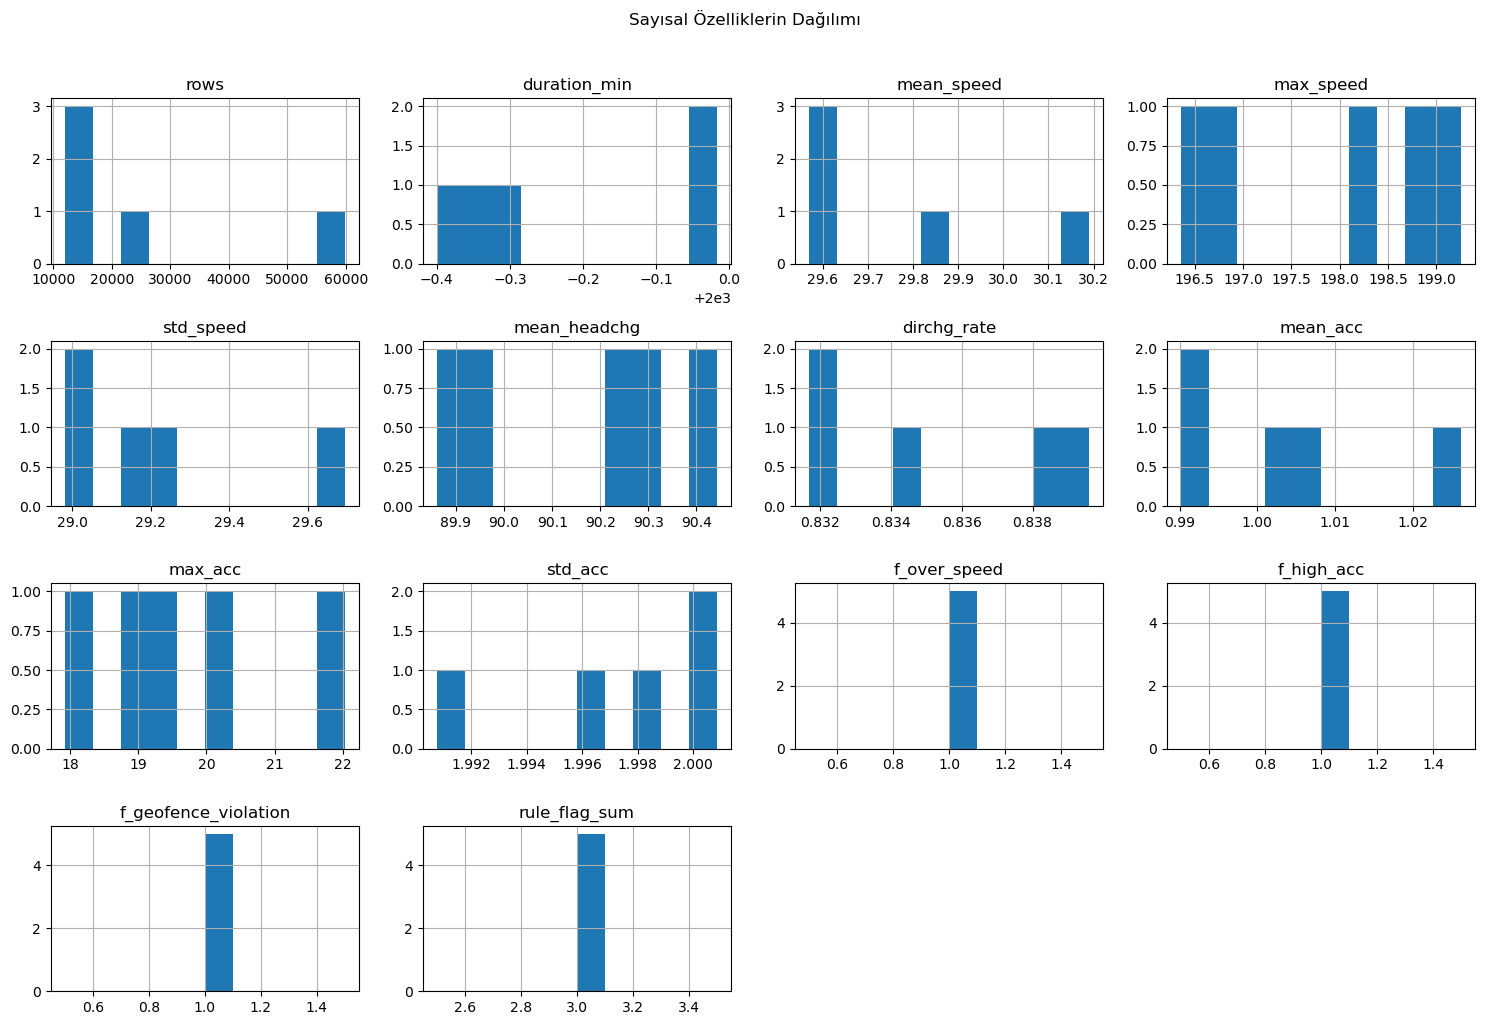


[GÖRSEL] Korelasyon Matrisi


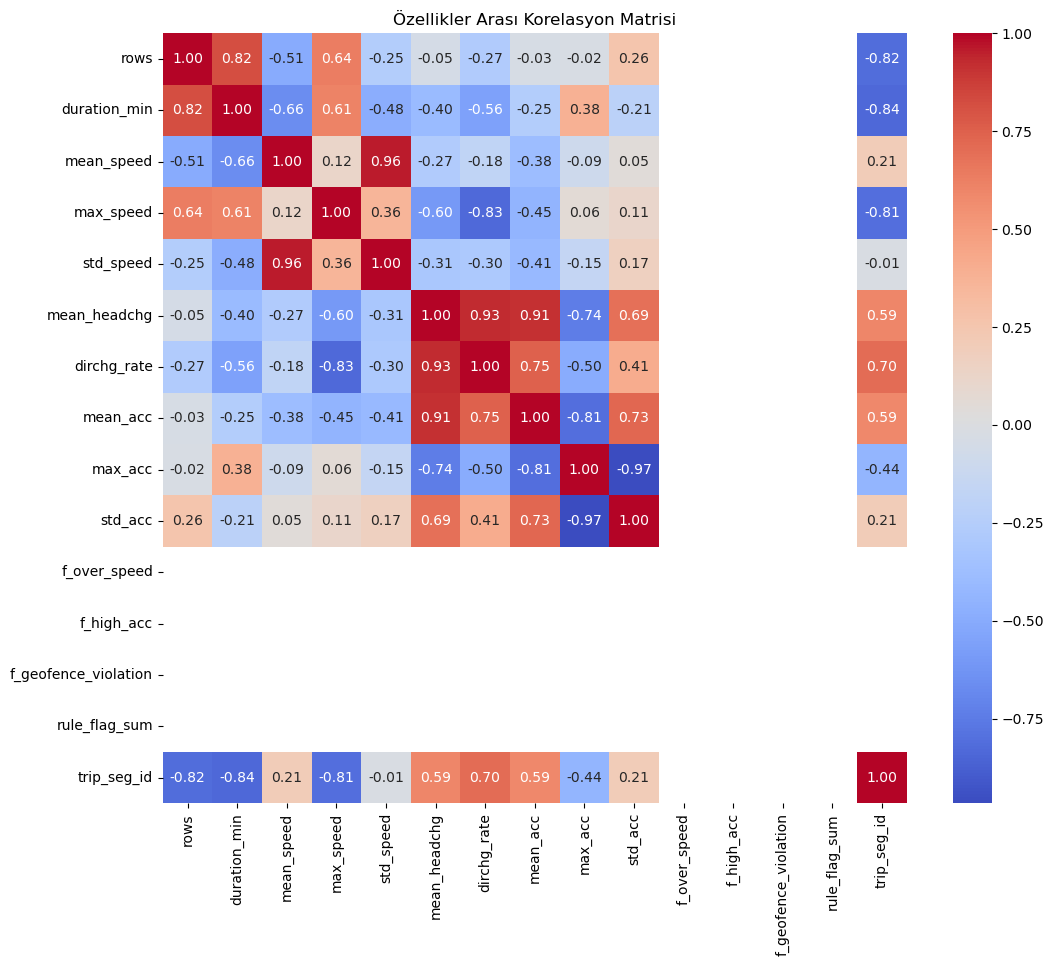


[TAMAMLANDI] QA sonrası EDA tamamlandı; bir sonraki adım (anomali tespiti / modelleme) için veri hazır.


In [8]:
# =========================================================
# Hücre 6: Yolculuk Bazında Özelliklerin Keşfi (EDA)
# =========================================================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROCESSED_DIR = "../data/processed"
INPUT_FILE = os.path.join(PROCESSED_DIR, "trip_features.csv")

print("\n=== Hücre 6: Yolculuk Bazında Özelliklerin Keşfi ===")
trip_features = pd.read_csv(INPUT_FILE)

# hızlı görünüm + temel istatistikler
print("\n[BİLGİ] İlk 5 satır:")
display(trip_features.head())
print("\n[İSTATİSTİK] Sayısal sütun özeti:")
display(trip_features.describe())

# histogramlar (trip_seg_id hariç)
num_cols = trip_features.select_dtypes(include=[np.number]).columns.tolist()
if "trip_seg_id" in num_cols:
    num_cols.remove("trip_seg_id")

print("\n[GÖRSEL] Sayısal Özelliklerin Dağılımı (Histogram)")
trip_features[num_cols].hist(bins=10, figsize=(15, 10))
plt.suptitle("Sayısal Özelliklerin Dağılımı", y=1.02)
plt.tight_layout()
plt.show()

# korelasyon ısı haritası
print("\n[GÖRSEL] Korelasyon Matrisi")
corr_cols = num_cols + (["trip_seg_id"] if "trip_seg_id" in trip_features.columns else [])
corr = trip_features[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Özellikler Arası Korelasyon Matrisi")
plt.show()

print("\n[TAMAMLANDI] QA sonrası EDA tamamlandı; bir sonraki adım (anomali tespiti / modelleme) için veri hazır.")


### **Aşama 6: Yolculuk Bazında Özelliklerin Keşfi (EDA) Özeti**

Bu aşamada, anomali tespiti için kullanacağımız özellik setini daha yakından tanımak amacıyla keşifsel veri analizi (EDA) gerçekleştirdik. Bu analiz, özelliklerin dağılımlarını ve birbirleriyle olan ilişkilerini anlamamızı sağladı.

**Analiz Bulguları:**
-   **Dağılımlar**: Histogramlar aracılığıyla her bir özelliğin (hız, ivme, yön değişimi oranı vb.) dağılımını gözlemledik. Bu, veri setindeki normal ve anormal değerlerin ilk görsel ayrımını yapmamıza yardımcı oldu.
-   **Korelasyonlar**: Korelasyon matrisi, özellikler arasındaki ilişkileri ortaya koydu. Örneğin, ortalama hız (`mean_speed`) ile maksimum hız (`max_speed`) arasında yüksek bir pozitif korelasyon bulunduğunu gördük, bu da beklenen bir durumdur.

**Sonuç:** Veri seti, anomali tespiti modelini eğitmek için kullanışlı ve anlamlı özellikler içermektedir. Elde edilen bulgular, bir sonraki aşamada modelleme için uygun özellikleri seçme ve modeli değerlendirme stratejisi oluşturma konusunda bize rehberlik edecektir.

In [9]:
# =========================================================
# Hücre 7/8: Kompozit Anomali Skoru Oluşturma, Kaydetme
# =========================================================
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

PROCESSED_DIR = "../data/processed"
INPUT_FILE = os.path.join(PROCESSED_DIR, "trip_features.csv")
OUTPUT_FILE = os.path.join(PROCESSED_DIR, "trip_features_scored.csv")

print("=== H7/8: Kompozit Anomali Skoru Başlatılıyor ===")

# --- Kaydedilmiş veri setini yükle (önceki hücrelerden)
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"[HATA] '{INPUT_FILE}' dosyası bulunamadı. Lütfen bir önceki hücreleri çalıştırdığınızdan emin olun.")
features = pd.read_csv(INPUT_FILE)

# --- IQR+1.5 Kuralı ile Dinamik Eşikler Oluşturma
def exists(col):
    return col in features.columns

def iqr_hi(s: pd.Series) -> float:
    s = s.dropna()
    if s.empty:
        return np.nan
    q1, q3 = np.percentile(s, [25, 75])
    return float(q3 + 1.5*(q3 - q1))

dynamic_flags = pd.DataFrame(index=features.index)
dynamic_flags['f_iqr_mean_speed'] = (
    features["mean_speed"] > iqr_hi(features["mean_speed"])
) if exists("mean_speed") else False
dynamic_flags['f_iqr_max_speed'] = (
    features["max_speed"] > iqr_hi(features["max_speed"])
) if exists("max_speed") else False
dynamic_flags['f_iqr_std_speed'] = (
    features["std_speed"] > iqr_hi(features["std_speed"])
) if exists("std_speed") else False
dynamic_flags['f_iqr_dirchg'] = (
    features["dirchg_rate"] > iqr_hi(features["dirchg_rate"])
) if exists("dirchg_rate") else False
dynamic_flags['f_iqr_mean_acc'] = (
    features["mean_acc"] > iqr_hi(features["mean_acc"])
) if exists("mean_acc") else False
dynamic_flags['f_iqr_std_acc'] = (
    features["std_acc"] > iqr_hi(features["std_acc"])
) if exists("std_acc") else False

# --- Tüm Bayrakları Birleştir
features_scored = features.copy()
features_scored = pd.concat([features_scored, dynamic_flags.astype(int)], axis=1)

# --- Toplam Kural Skorunu Güncelle
# NOT: Bu kısım, H4'ten gelen statik bayraklarla H7'deki dinamik bayrakları birleştirir.
static_flag_cols = ['f_over_speed', 'f_high_acc', 'f_geofence_violation']
dynamic_flag_cols = list(dynamic_flags.columns)
all_flag_cols = static_flag_cols + dynamic_flag_cols
features_scored["rule_flag_sum_final"] = features_scored[all_flag_cols].sum(axis=1)

print("\n[TAMAMLANDI] Kural tabanlı anomali bayrakları başarıyla oluşturuldu.")
print("Güncellenmiş bayraklar:", list(dynamic_flags.columns))
print("Nihai Toplam Kural Skoru:", features_scored['rule_flag_sum_final'].sum())

# --- Makine Öğrenmesi İçin Kompozit Skor Oluşturma (H8'den)
print("\n[BAŞLATILIYOR] Makine öğrenmesi için kompozit skor oluşturuluyor.")

score_cols = [
    "mean_speed", "max_speed", "std_speed", "dirchg_rate", "mean_acc", "std_acc"
]
X = features_scored[score_cols].values
scaler = StandardScaler()
Z = scaler.fit_transform(X)
features_scored["anomaly_score_ml"] = Z.mean(axis=1)

print("[TAMAMLANDI] Kompozit skor 'anomaly_score_ml' oluşturuldu.")

# --- Sıralama ve Kayıt
features_scored.sort_values("anomaly_score_ml", ascending=False, inplace=True)
features_scored.to_csv(OUTPUT_FILE, index=False)

print(f"\n[OK] Nihai skorlu dosya kaydedildi: {OUTPUT_FILE}")
print("Nihai Boyut:", f"{features_scored.shape[0]} satır x {features_scored.shape[1]} sütun")
print("En Şüpheli İlk 5 Segment:")
cols_to_show = ["trip_seg_id", "rule_flag_sum_final", "anomaly_score_ml"] + all_flag_cols
display(features_scored[cols_to_show].head())

=== H7/8: Kompozit Anomali Skoru Başlatılıyor ===

[TAMAMLANDI] Kural tabanlı anomali bayrakları başarıyla oluşturuldu.
Güncellenmiş bayraklar: ['f_iqr_mean_speed', 'f_iqr_max_speed', 'f_iqr_std_speed', 'f_iqr_dirchg', 'f_iqr_mean_acc', 'f_iqr_std_acc']
Nihai Toplam Kural Skoru: 16

[BAŞLATILIYOR] Makine öğrenmesi için kompozit skor oluşturuluyor.
[TAMAMLANDI] Kompozit skor 'anomaly_score_ml' oluşturuldu.

[OK] Nihai skorlu dosya kaydedildi: ../data/processed/trip_features_scored.csv
Nihai Boyut: 5 satır x 25 sütun
En Şüpheli İlk 5 Segment:


,trip_seg_id,rule_flag_sum_final,anomaly_score_ml,f_over_speed,f_high_acc,f_geofence_violation,f_iqr_mean_speed,f_iqr_max_speed,f_iqr_std_speed,f_iqr_dirchg,f_iqr_mean_acc,f_iqr_std_acc
2,3,4,0.489995,1,1,1,0,0,1,0,0,0
4,5,3,0.229784,1,1,1,0,0,0,0,0,0
0,1,3,0.169092,1,1,1,0,0,0,0,0,0
3,4,3,0.016210,1,1,1,0,0,0,0,0,0
1,2,3,-0.905082,1,1,1,0,0,0,0,0,0


### ✅ Özellik Mühendisliği (Feature Engineering) Aşaması Tamamlandı!

Bu not defterini başarıyla tamamladınız. Artık makine öğrenmesi modelinizin eğitimi ve anomali tespiti için gerekli olan tüm veriye sahipsiniz.

**Bu aşamada elde ettiğimiz çıktılar:**

1.  **`trip_features.csv`**: Ham veriden türetilen çeşitli özelliklerin (hız, ivme, süre, vb.) bulunduğu ana veri seti.
2.  **`validation_report.json`**: `trip_features.csv` dosyasının kalitesini doğrulayan ve olası veri sorunlarını özetleyen bir rapor.
3.  **`trip_features_scored.csv`**:
    * Kural tabanlı (statik ve dinamik) anomali bayraklarını içeren nihai veri seti.
    * Makine öğrenmesi modelleri için kullanılacak kompozit anomali skorlarını (`anomaly_score_ml`) içeren nihai veri seti.

### Sonraki Adım: Anomali Tespiti Modelleri

Sırada projenizin en heyecan verici kısmı var: **`04_anomaly_detection.ipynb`**. Bu not defterinde, hazırladığımız `trip_features_scored.csv` dosyasını kullanarak çeşitli anomali tespiti modellerini (örneğin, Isolation Forest, Local Outlier Factor) eğitecek ve değerlendireceğiz.

Hazırsanız, bir sonraki not defterine geçebiliriz!

En Şüpheli İlk 5 Segment:
   trip_seg_id  rule_flag_sum_final  anomaly_score_ml
0            3                    4          0.489995
1            5                    3          0.229784
2            1                    3          0.169092
3            4                    3          0.016210
4            2                    3         -0.905082


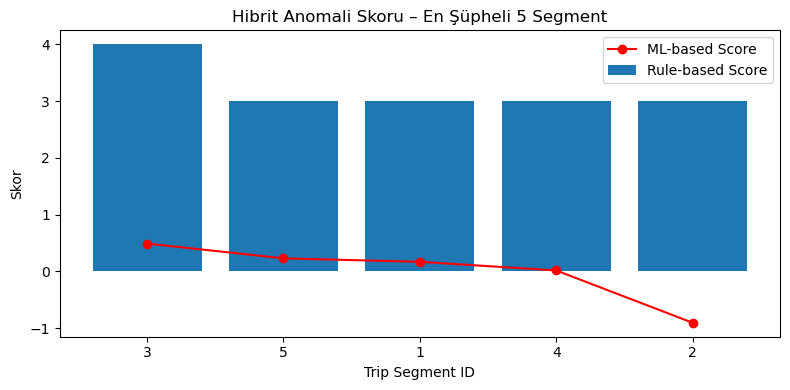

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Skorlu veri setini oku
df = pd.read_csv("../data/processed/trip_features_scored.csv")

# En şüpheli ilk 5 segmenti seç
cols_to_show = ["trip_seg_id", "rule_flag_sum_final", "anomaly_score_ml"]
top5 = df[cols_to_show].head()

# Tablo çıktısı
print("En Şüpheli İlk 5 Segment:")
print(top5)

# Görsel (rule_flag_sum_final ve anomaly_score_ml karşılaştırması)
plt.figure(figsize=(8,4))
plt.bar(top5["trip_seg_id"].astype(str), top5["rule_flag_sum_final"], label="Rule-based Score")
plt.plot(top5["trip_seg_id"].astype(str), top5["anomaly_score_ml"], marker="o", color="red", label="ML-based Score")
plt.xlabel("Trip Segment ID")
plt.ylabel("Skor")
plt.title("Hibrit Anomali Skoru – En Şüpheli 5 Segment")
plt.legend()
plt.tight_layout()
plt.show()